In [1]:
# Import dependencies

# Python SQL toolkit and Object Relational Mapper
# engine, inspect, and functions
from sqlalchemy import create_engine, inspect, func

# Declarative base because when you want something done right... you don't use automap...
from sqlalchemy.ext.declarative import declarative_base

# Columns and data types
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.types import Date, Time

# Session for queries
from sqlalchemy.orm import Session

# Operations for queries
from sqlalchemy.sql.expression import and_, or_, extract

%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Formatting tool for notebook
%reload_ext lab_black
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
session = Session(bind=engine)
inspector = inspect(engine)

In [4]:
# Read table names
table_names = inspector.get_table_names()
table_names

['measurement', 'station']

In [5]:
# Show data in tables
for table_name in table_names:
    print(f"TABLE: {table_name}")
    columns = inspector.get_columns(table_name)
    pprint(columns)
    sample = engine.execute(f"SELECT * FROM {table_name} LIMIT 5")
    print(f"DATA FROM TABLE {table_name}: ")
    for row in sample:
        print(row)

TABLE: measurement
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]
DATA FROM TABLE measurement: 
(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
TABLE: station
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primar

In [6]:
# Create classes
Base = declarative_base()


class Measurement(Base):
    __tablename__ = "measurement"
    id = Column(Integer, primary_key=True)
    station = Column(String(30))
    date = Column(Date)
    prcp = Column(Float)
    tobs = Column(Float)


class Station(Base):
    __tablename__ = "station"
    id = Column(Integer, primary_key=True)
    station = Column(String(30))
    name = Column(String(120))
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)

# Exploratory Climate Analysis

In [7]:
# Find min and max dates in data
min_date, max_date = session.query(
    func.min(Measurement.date), func.max(Measurement.date)
).first()
print(f"Measurement table time range - start date: {min_date} and end date: {max_date}")

Measurement table time range - start date: 2010-01-01 and end date: 2017-08-23


In [8]:
# Calculate the date 1 year ago from the last data point in the database
start_date = max_date - relativedelta(years=1)
end_date = max_date
print(f"Dates from the last year - start date: {start_date} and end date {end_date}")

Dates from the last year - start date: 2016-08-23 and end date 2017-08-23


In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = (
    session.query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date >= start_date)
    .filter(Measurement.date <= end_date)
    .group_by(Measurement.date)
)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = (
    pd.read_sql(query.statement, query.session.bind, index_col="date")
    .rename(columns={"avg_1": "precipitation"})
    .sort_index()
)
prcp_df.head()

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


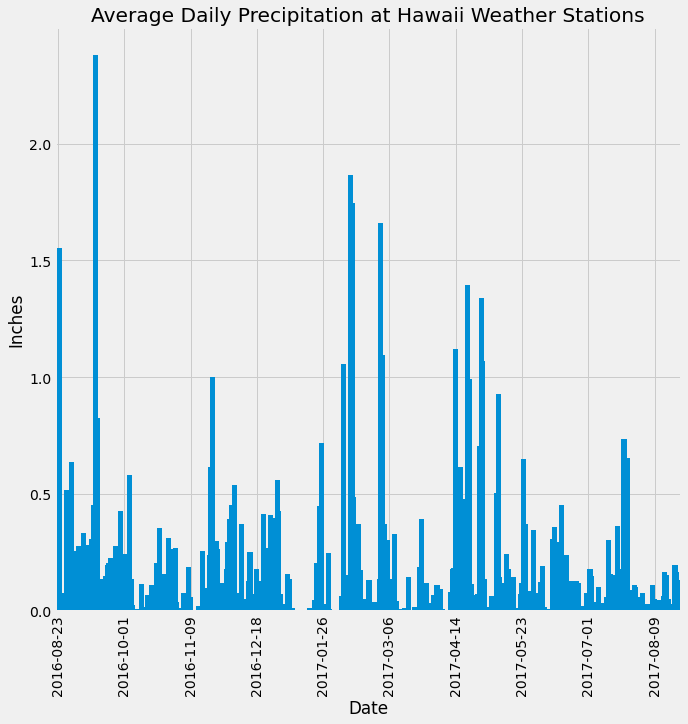

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(
    kind="bar",
    title="Average Daily Precipitation at Hawaii Weather Stations",
    figsize=(10, 10),
    width=3,
    legend=False,
)
plt.locator_params(axis="x", nbins=9.5)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_station_measurement = len(session.query(Measurement.station).distinct().all())
print(f"Number of stations in Measurement table: {num_station_measurement}")

num_station = len(session.query(Station.station).distinct().all())
print(f"Number of stations in Station table: {num_station}")

Number of stations in Measurement table: 9
Number of stations in Station table: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
)
print(
    f"Station {active_station.first()[0]} has the most temp and precipitation reports: {active_station.first()[1]}"
)

Station USC00519281 has the most temp and precipitation reports: 2772


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?

temp_range = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == "USC00519281")
    .first()
)
print(f"Temperature range for station USC00519281")
print(
    f"Lowest Temp: {temp_range[0]:.2f}, Highest Temp: {temp_range[1]:.2f}, Avg Temp: {temp_range[2]:.2f}"
)

Temperature range for station USC00519281
Lowest Temp: 54.00, Highest Temp: 85.00, Avg Temp: 71.66


In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

min_date, max_date = (
    session.query(func.min(Measurement.date), func.max(Measurement.date))
    .filter(Measurement.station == "USC00519281")
    .first()
)
print(f"Start date {min_date} and end date {max_date} for station USC00519281")

start_date = max_date - relativedelta(years=1)
end_date = max_date
print(
    f"Dates to use in the past year of station USC00519281 - start date {start_date} and end date {end_date}"
)

query = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == "USC00519281")
    .filter(Measurement.date >= start_date)
    .filter(Measurement.date <= end_date)
)

temp_df = (
    pd.read_sql(query.statement, query.session.bind, index_col="date")
    .rename(columns={"tobs": "temperature"})
    .sort_index()
)
temp_df.head()

Start date 2010-01-01 and end date 2017-08-18 for station USC00519281
Dates to use in the past year of station USC00519281 - start date 2016-08-18 and end date 2017-08-18


,temperature
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


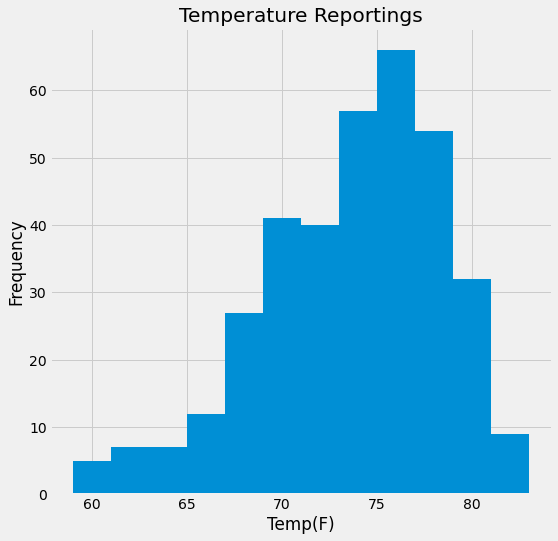

In [16]:
temp_df.plot(
    kind="hist", title="Temperature Reportings", bins=12, legend=False, figsize=(8, 8)
)
plt.xlabel("Temp(F)")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

prev_year_start = dt.date(2018, 5, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 5, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(
    prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d")
)[0]

print(f"{tmin}, {tavg:.2f}, {tmax}")
t = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))

65.0, 75.67, 80.0


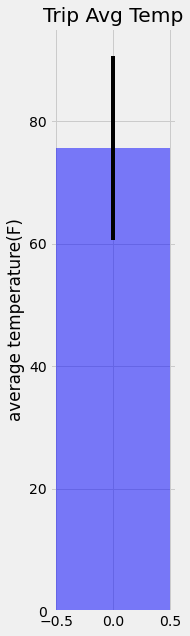

In [25]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = t[0][0]
tavg = t[0][1]
tmax = t[0][2]
yerr = tmax - tmin

plt.figure(figsize=(2, 10))
plt.bar(0, tavg, yerr=yerr, align="center", width=1, color="blue", alpha=0.5)
plt.ylim = (0, 100)
plt.ylabel("average temperature(F)")
plt.title("Trip Avg Temp")
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = "2017-05-01"
end_date = "2017-05-07"

sel = [
    Station.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.sum(Measurement.prcp),
]

results = (
    session.query(*sel)
    .filter(Measurement.station == Station.station)
    .filter(Measurement.date >= start_date)
    .filter(Measurement.date <= end_date)
    .group_by(Station.name)
    .order_by(func.sum(Measurement.prcp).desc())
    .all()
)

print("Station \t Name \t\t\t\t\t  Latitude \t Longitude \t Elevation \t Rainfall")
print(
    "------------------------------------------------------------------------------------------------------------------"
)

for (station, name, latitude, longitude, elevation, rainfall) in results:
    print(
        station,
        "\t",
        "{:<40}".format(name),
        latitude,
        "\t",
        round(longitude, 2),
        "\t",
        elevation,
        "\t\t",
        rainfall,
    )

Station 	 Name 					  Latitude 	 Longitude 	 Elevation 	 Rainfall
------------------------------------------------------------------------------------------------------------------
USC00514830 	 KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213 	 -157.84 	 7.0 		 0.47000000000000003
USC00516128 	 MANOA LYON ARBO 785.2, HI US             21.3331 	 -157.8 	 152.4 		 0.38
USC00519397 	 WAIKIKI 717.2, HI US                     21.2716 	 -157.82 	 3.0 		 0.26
USC00513117 	 KANEOHE 838.1, HI US                     21.4234 	 -157.8 	 14.6 		 0.18
USC00519281 	 WAIHEE 837.5, HI US                      21.45167 	 -157.85 	 32.9 		 0.17
USC00519523 	 WAIMANALO EXPERIMENTAL FARM, HI US       21.33556 	 -157.71 	 19.5 		 0.07


In [21]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = "2018-05-01"
trip_end = "2018-05-07"

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq="D")

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
normals

[(65.0, 72.75925925925925, 79.0),
 (65.0, 73.05084745762711, 79.0),
 (67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0),
 (67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
df["date"] = trip_dates
df.set_index(["date"], inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-05-01,65.0,72.759259,79.0
2018-05-02,65.0,73.050847,79.0
2018-05-03,67.0,73.410714,84.0
2018-05-04,65.0,73.596491,78.0
2018-05-05,67.0,73.396552,79.0


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Text(9.310000000000002, 0.5, 'Temperature')

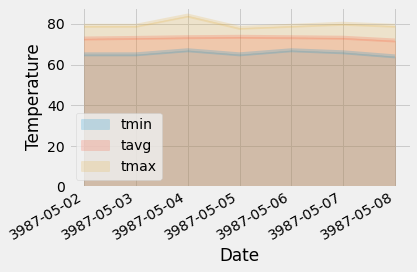

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind="area", stacked=False, x_compat=True, alpha=0.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")